In [1]:
import pandas as pd 
import seaborn as sns
import random
from cv2 import resize
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train_data_dir = '/kaggle/input/cnn-data/CNN data/train'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 80
SHUFFLE_BUFFER = 1000
PRETRAINED_MODEL_PATH = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2"
validation_split = 0.2 


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=42,
    validation_split=validation_split, 
    subset='training',
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=42,
    validation_split=validation_split,  
    subset='validation',
)


Found 12355 files belonging to 11 classes.
Using 9884 files for training.
Found 12355 files belonging to 11 classes.
Using 2471 files for validation.


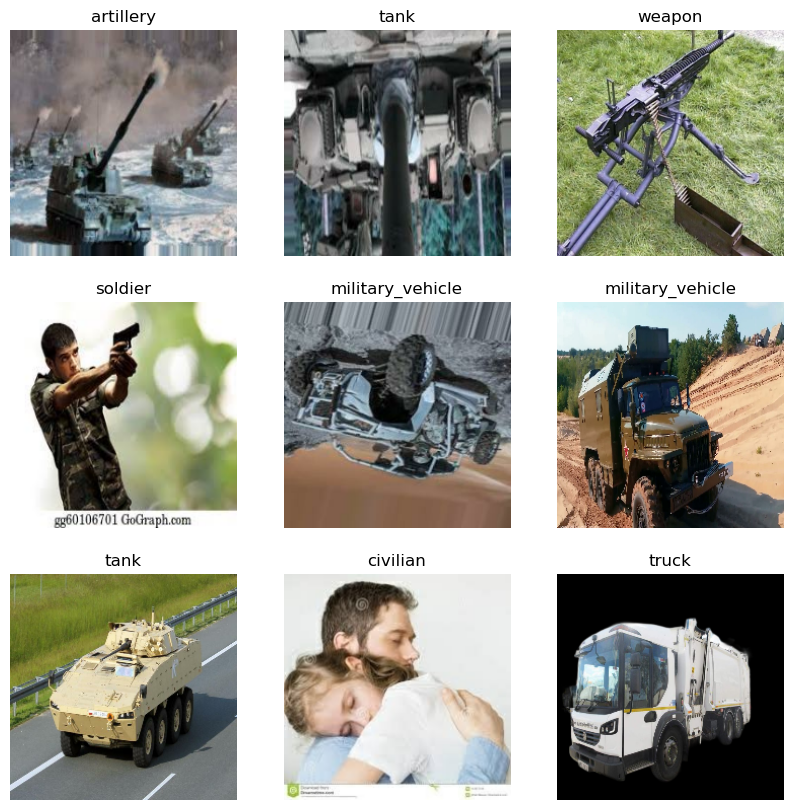

['aircraft', 'artillery', 'camouflage', 'civilian', 'civilian vehicle', 'military_vehicle', 'soldier', 'tank', 'truck', 'warship', 'weapon']


In [4]:
class_names = train_dataset.class_names


plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        image = images[i].numpy()  
        label = labels[i]
        class_name = class_names[tf.argmax(label)]
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.astype("uint8"))  
        plt.title(class_name)
        plt.axis("off")  
plt.show()
print(class_names)

In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.Rescaling(1/255.)
], name="data_augmentation")

normalization = layers.Rescaling(1/255.)


In [6]:
training_data = (train_dataset.map(lambda x, y: (data_augmentation(x), y))
                 .shuffle(SHUFFLE_BUFFER)
                 .prefetch(buffer_size=AUTOTUNE)
                 .cache())

validation_data = (validation_dataset.map(lambda x, y: (normalization(x), y))
                   .prefetch(buffer_size=AUTOTUNE)
                   .cache())


In [7]:
keras_layer = hub.KerasLayer(PRETRAINED_MODEL_PATH)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='weights.ckpt',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True)
]


In [8]:
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = keras_layer(inputs)
x = tf.keras.layers.Dense(224, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_resnet = keras.Model(inputs, outputs)
model_resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 224)               224448    
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                2475      
                                                                 
Total params: 25,842,772
Trainable params: 226,923
Non-trainable params: 25,615,849
_________________________________________________________________


In [9]:
model_resnet.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

callbacks.append(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1)
)

history_resnet = model_resnet.fit(training_data,
                    epochs=EPOCHS,
                    validation_data=validation_data,
                    callbacks=callbacks)


Epoch 1/80
309/309 [==============================] - 154s 132ms/step - loss: 1.7600 - accuracy: 0.5253 - val_loss: 0.5263 - val_accuracy: 0.8325 - lr: 1.0000e-04
Epoch 2/80
309/309 [==============================] - 34s 109ms/step - loss: 0.8407 - accuracy: 0.7305 - val_loss: 0.4040 - val_accuracy: 0.8701 - lr: 1.0000e-04
Epoch 3/80
309/309 [==============================] - 36s 115ms/step - loss: 0.6555 - accuracy: 0.7808 - val_loss: 0.3534 - val_accuracy: 0.8891 - lr: 1.0000e-04
Epoch 4/80
309/309 [==============================] - 35s 112ms/step - loss: 0.5718 - accuracy: 0.8128 - val_loss: 0.3317 - val_accuracy: 0.8883 - lr: 1.0000e-04
Epoch 5/80
309/309 [==============================] - 35s 112ms/step - loss: 0.4902 - accuracy: 0.8407 - val_loss: 0.3120 - val_accuracy: 0.8968 - lr: 1.0000e-04
Epoch 6/80
309/309 [==============================] - 35s 113ms/step - loss: 0.4334 - accuracy: 0.8541 - val_loss: 0.2967 - val_accuracy: 0.9017 - lr: 1.0000e-04
Epoch 7/80
309/309 [=======

In [10]:

results = model_resnet.evaluate(validation_data)

print("Validation Loss:", results[0])
print("Validation Accuracy:", results[1])

78/78 [==============================] - 7s 87ms/step - loss: 0.2446 - accuracy: 0.9195
Validation Loss: 0.24460025131702423
Validation Accuracy: 0.9194657802581787


1/1 [==============================] - 1s 504ms/step


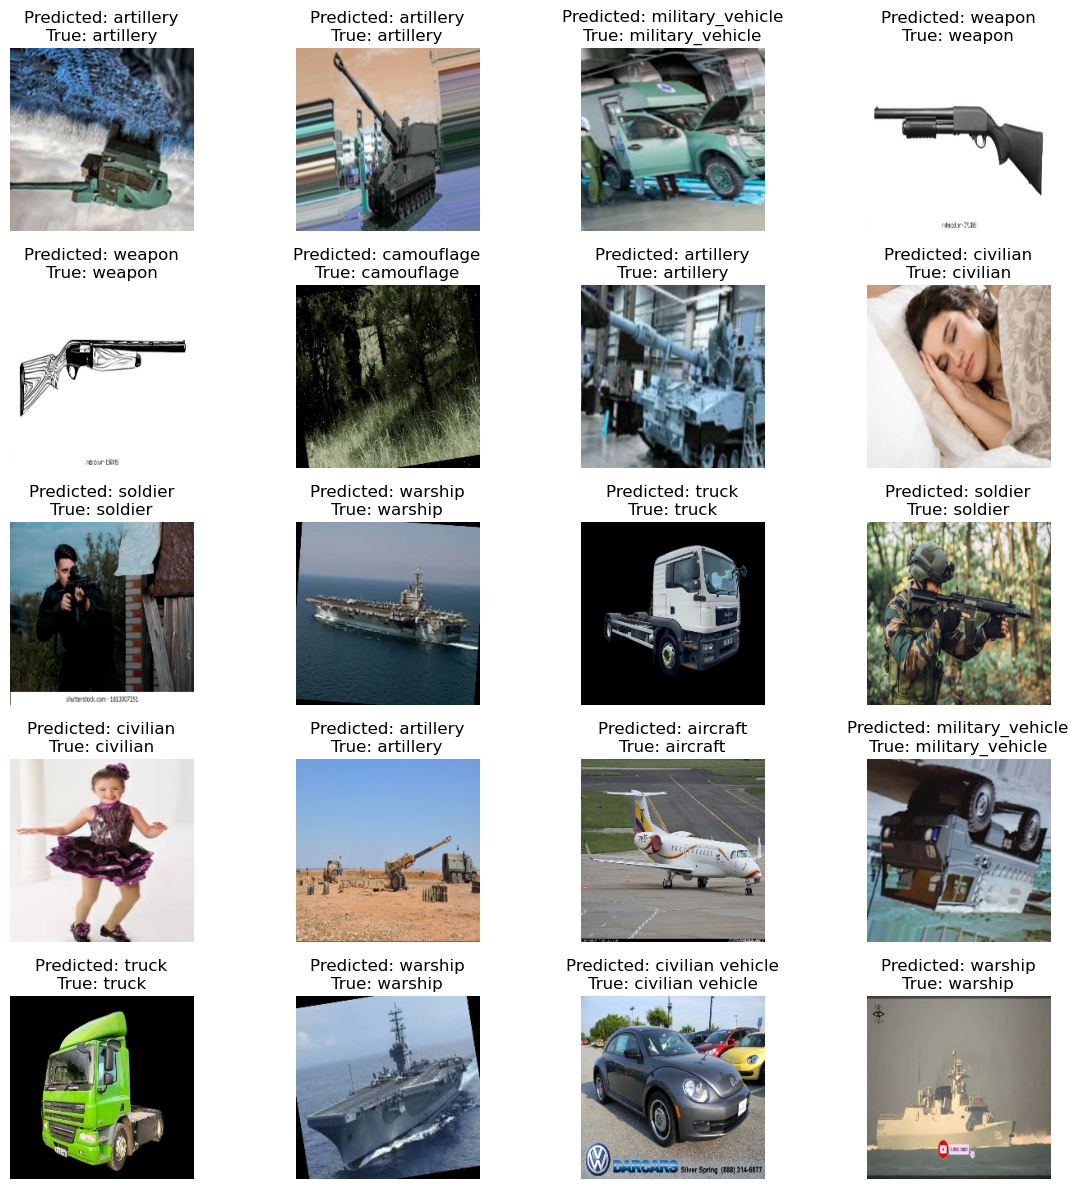

In [11]:
num_rows = 5
num_cols = 4
plt.figure(figsize=(12, 12))

for images, labels in validation_dataset:
    images_normalized = normalization(images)
    
    predictions = model_resnet.predict(images_normalized)
    
    for i in range(images.shape[0]):
        image = images[i].numpy()
        label = labels[i]
        

        predicted_class_index = tf.argmax(predictions[i])
        predicted_class_name = class_names[predicted_class_index]
        
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image.astype("uint8"))
        plt.title(f"Predicted: {predicted_class_name}\nTrue: {class_names[tf.argmax(label)]}")
        plt.axis("off")
        
        if i == num_rows * num_cols - 1:
            break

    plt.tight_layout()
    plt.show()
    
    if i == num_rows * num_cols - 1:
        break

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

true_labels = []
pred_labels = []

for images, labels in validation_dataset:
    predictions = model_resnet.predict(normalization(images))
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
    pred_labels.extend(tf.argmax(predictions, axis=1).numpy())

print(classification_report(true_labels, pred_labels, target_names=class_names))


1/1 [==============================] - 0s 421ms/step
                  precision    recall  f1-score   support

        aircraft       0.96      0.90      0.93       236
       artillery       0.82      0.79      0.81       224
      camouflage       0.93      0.94      0.94       199
        civilian       0.96      0.96      0.96       210
civilian vehicle       0.97      0.98      0.98       228
military_vehicle       0.90      0.88      0.89       219
         soldier       0.91      0.90      0.90       229
            tank       0.78      0.83      0.81       236
           truck       1.00      1.00      1.00       212
         warship       0.98      0.98      0.98       236
          weapon       0.92      0.95      0.93       242

        accuracy                           0.92      2471
       macro avg       0.92      0.92      0.92      2471
    weighted avg       0.92      0.92      0.92      2471



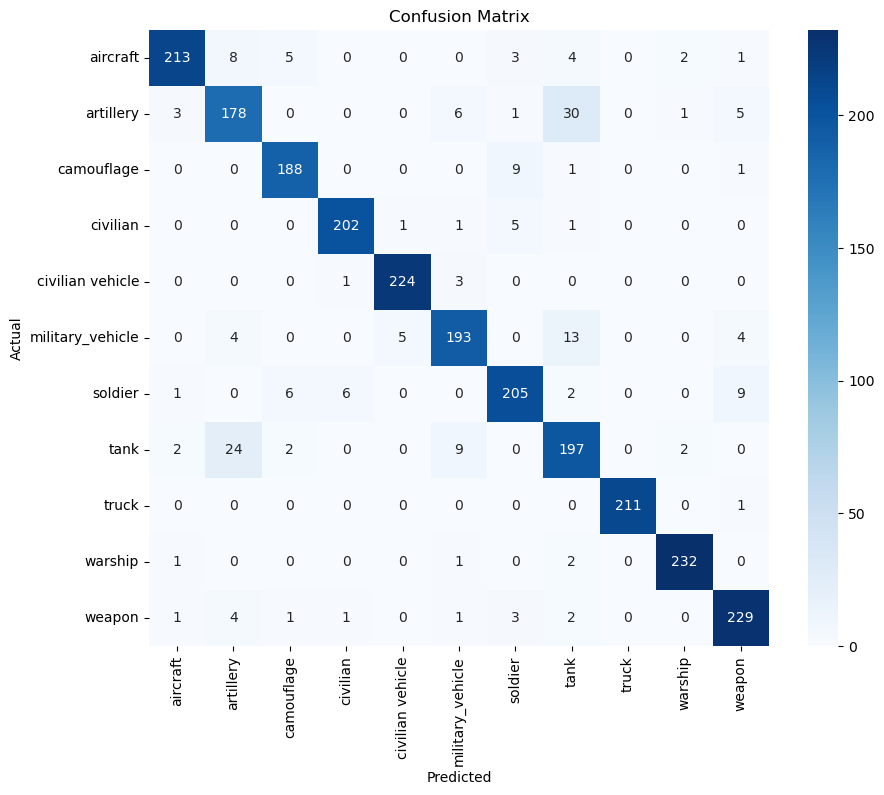

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


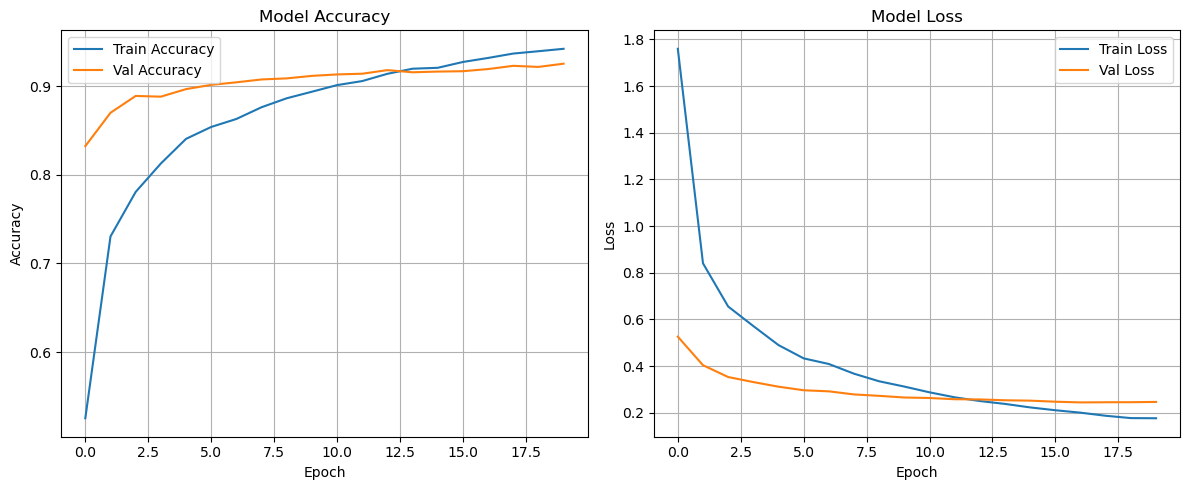

In [14]:
# Plot accuracy and loss from training
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


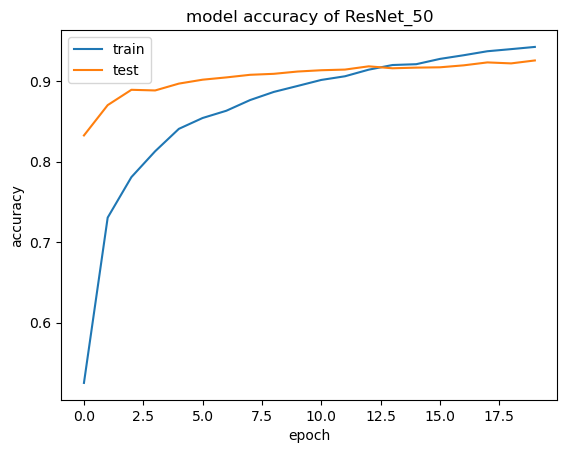

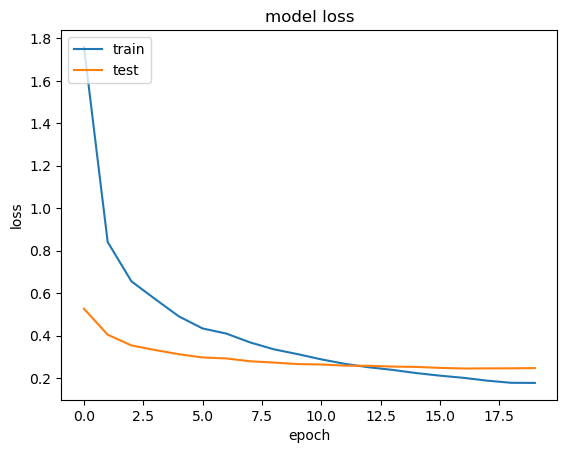

In [15]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('model accuracy of ResNet_50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
plt.savefig("confusion_matrix.png") 
plt.savefig("training_accuracy_loss.png")
model_resnet.save("model_resnet.keras")

<Figure size 640x480 with 0 Axes>